<a href="https://colab.research.google.com/github/dong-uk-kim97/Aiffel_project/blob/main/GoingDeeper_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 환경 설정 및 필요한 라이브러리 import

In [ ]:
# ! pip uninstall -y tensorflow
# ! pip uninstall -y numpy
# ! pip uninstall -y keras
# ! pip uninstall -y tensorflow_datasets
# ! pip install  tensorflow==2.6.0
# ! pip install keras==2.6.0
# ! pip install  numpy==1.21.4
# ! pip install tensorflow_datasets==4.4.0

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

# 1. Augmentation을 적용한 데이터셋 만들기

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


- split=  분할

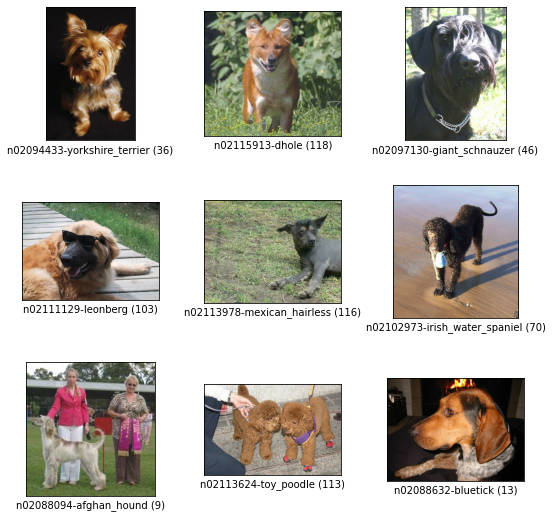

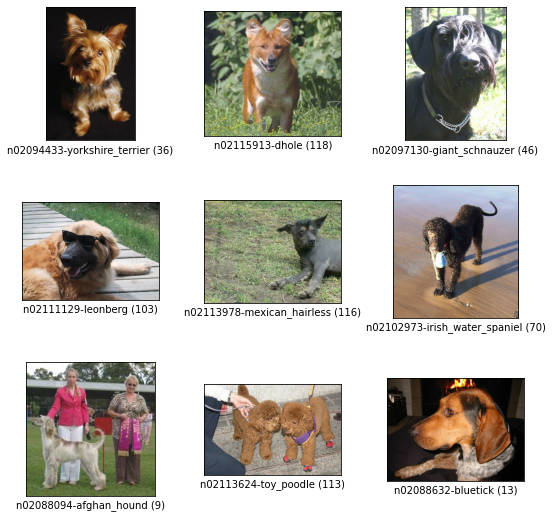

In [ ]:
tfds.show_examples(ds_train, ds_info)

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 2. Resnet-50 모델 만들기

In [ ]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [ ]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
750/750 [==============================] - 174s 204ms/step - loss: 2.1996 - accuracy: 0.4479 - val_loss: 3.2674 - val_accuracy: 0.2238
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 0.7434 - accuracy: 0.7920 - val_loss: 1.1072 - val_accuracy: 0.6796
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 0.2618 - accuracy: 0.9392 - val_loss: 0.9311 - val_accuracy: 0.7199
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0764 - accuracy: 0.9912 - val_loss: 0.8864 - val_accuracy: 0.7438
Epoch 5/20
750/750 [==============================] - 158s 210ms/step - loss: 0.0304 - accuracy: 0.9988 - val_loss: 0.8960 - val_accuracy: 0.7471
Epoch 6/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0181 - accuracy: 0.9994 - val_loss: 0.8933 - val_accuracy: 0.7515
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0116 - accuracy: 0.9999 - val_loss: 0.9139 -

In [ ]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 167s 211ms/step - loss: 2.2666 - accuracy: 0.4329 - val_loss: 2.7968 - val_accuracy: 0.3011
Epoch 2/20
750/750 [==============================] - 170s 227ms/step - loss: 0.9708 - accuracy: 0.7265 - val_loss: 1.2760 - val_accuracy: 0.6245
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 0.5455 - accuracy: 0.8441 - val_loss: 1.2540 - val_accuracy: 0.6347
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 0.2995 - accuracy: 0.9255 - val_loss: 1.0338 - val_accuracy: 0.6999
Epoch 5/20
750/750 [==============================] - 156s 208ms/step - loss: 0.1539 - accuracy: 0.9686 - val_loss: 1.0817 - val_accuracy: 0.7027
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0900 - accuracy: 0.9853 - val_loss: 0.9922 - val_accuracy: 0.7285
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0772 - accuracy: 0.9879 - val_loss: 1.0080 -

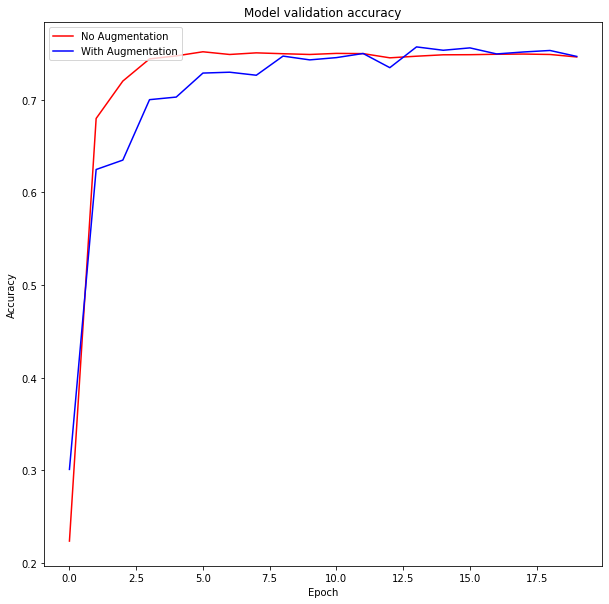

In [ ]:
figure = plt.figure(figsize=(10, 10))

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

epochs가 2를 넘어가면서 no_augmentation이 더 높게 나오는 것을 확인할 수 있다. epochs가 3이 넘어가면서 overfitting이 일어나기 때문에 epochs 2일 때까지만 신뢰할 수 있다고 생각한다 그렇게 보면 augmentation 한 것이 더 좋은 결과를 얻을 수 있다고 생각한다.

# 심화 Augmentation

Cutmix

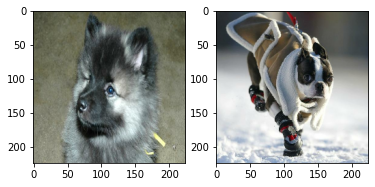

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(103, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(114, shape=(), dtype=int32)


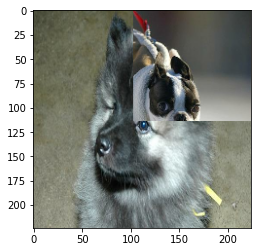

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [ ]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.2749123, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

mixup

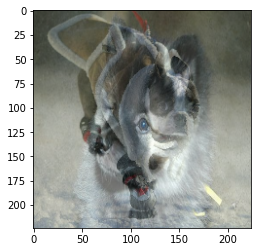

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.4400494 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

In [ ]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 169s 212ms/step - loss: 3.8325 - accuracy: 0.2067 - val_loss: 3.7555 - val_accuracy: 0.1559
Epoch 2/20
750/750 [==============================] - 158s 210ms/step - loss: 2.9341 - accuracy: 0.4392 - val_loss: 1.3170 - val_accuracy: 0.6400
Epoch 3/20
750/750 [==============================] - 158s 210ms/step - loss: 2.6408 - accuracy: 0.5277 - val_loss: 1.3750 - val_accuracy: 0.6206
Epoch 4/20
750/750 [==============================] - 158s 210ms/step - loss: 2.4092 - accuracy: 0.6058 - val_loss: 1.2143 - val_accuracy: 0.6595
Epoch 5/20
750/750 [==============================] - 158s 210ms/step - loss: 2.2547 - accuracy: 0.6590 - val_loss: 1.2536 - val_accuracy: 0.6611
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 2.1683 - accuracy: 0.6813 - val_loss: 1.1954 - val_accuracy: 0.6793
Epoch 7/20
750/750 [==============================] - 157s 210ms/step - loss: 2.0758 - accuracy: 0.7111 - val_loss: 1.2630 -

In [ ]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 167s 212ms/step - loss: 3.7017 - accuracy: 0.2503 - val_loss: 3.9480 - val_accuracy: 0.1271
Epoch 2/20
750/750 [==============================] - 157s 210ms/step - loss: 2.8439 - accuracy: 0.4863 - val_loss: 1.5063 - val_accuracy: 0.5821
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 2.5809 - accuracy: 0.5842 - val_loss: 1.3455 - val_accuracy: 0.6302
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 2.3818 - accuracy: 0.6638 - val_loss: 1.2983 - val_accuracy: 0.6390
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 2.2379 - accuracy: 0.7120 - val_loss: 1.3094 - val_accuracy: 0.6446
Epoch 6/20
750/750 [==============================] - 158s 211ms/step - loss: 2.1354 - accuracy: 0.7483 - val_loss: 1.2266 - val_accuracy: 0.6632
Epoch 7/20
750/750 [==============================] - 159s 212ms/step - loss: 2.0810 - accuracy: 0.7728 - val_loss: 1.2859 -

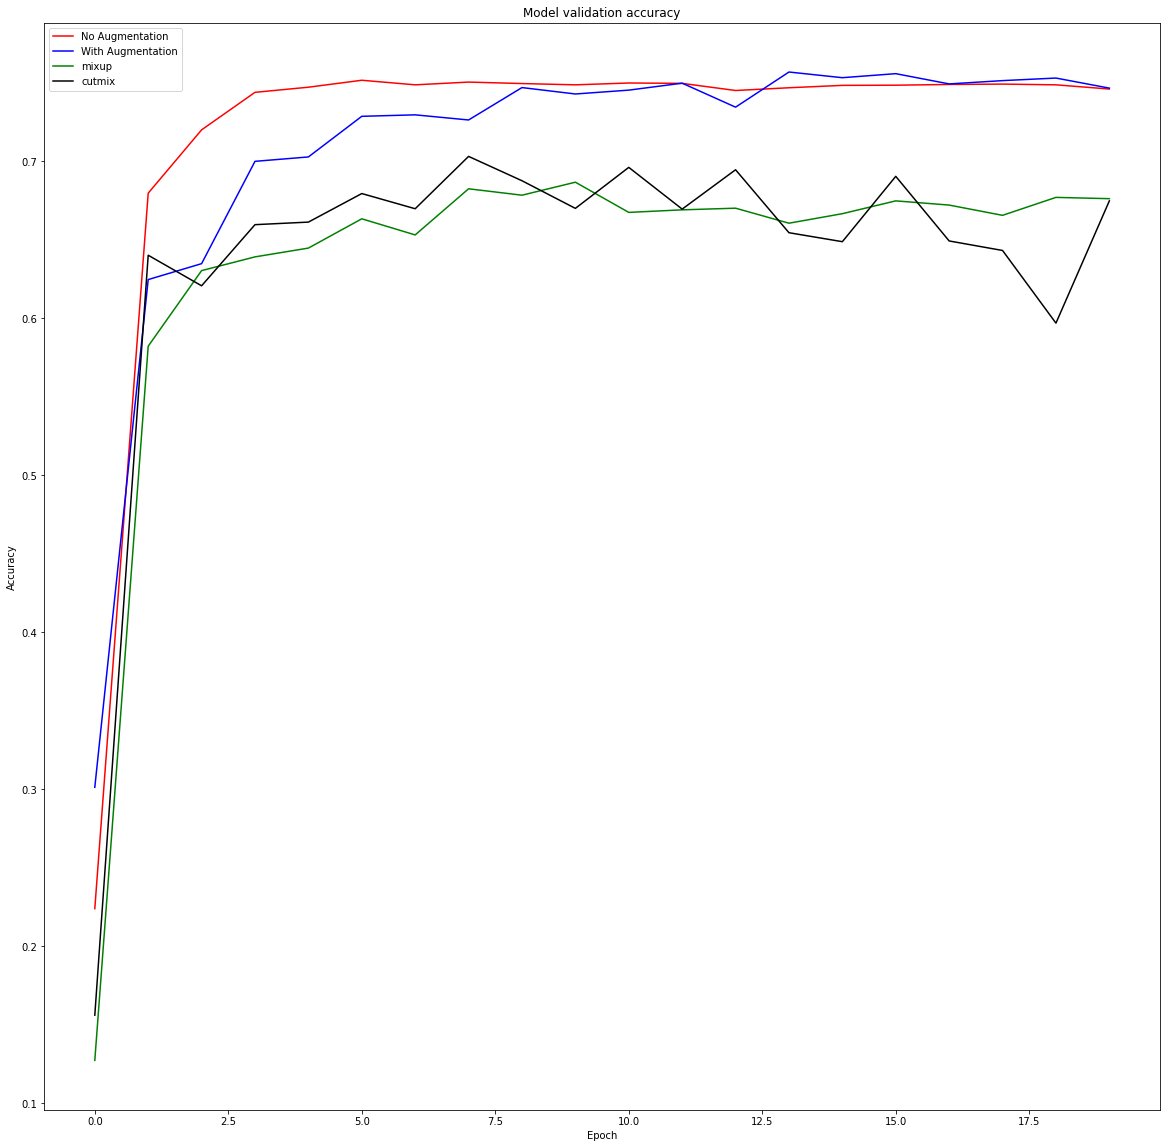

In [ ]:
figure = plt.figure(figsize=(10, 10))

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'black')


plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'mixup', 'cutmix'], loc='best')
plt.show()

mixup과 cutmix가 좋지 않은 성능을 보인 이유는 dataset이 단순한데 resnet50은 model complexity가 높다는 추측이 된다.

그리고 overfitting이 epochs 2 이후로 일어나기 때문에 그 전으로 보자면 기본 augmentation>no augmentation>cutmix>mixup 순으로 높은 성능을 보인다.

기본 augmentation이 단순한 dataset에서 적합하다는 것을 확인할 수 있었다.

# 출처
https://github.com/museonghwang/AIFFEL/blob/master/GoingDeeper_04/%5BGD-04%5D%20Cutmix%20and%20Mixup%20Augmentation%20compare.ipynb

# 회고

기본 augmentation을 brightness와 random_flip_left_right를 했는데 이것을 사용해도 굉장히 성능이 좋아진다는 것을 깨달았다.

그리고 파이프라인에 대한 이해가 부족한 것 같다. 이 노드에서 파이프라인을 정리하지 못해서 다음 노드에서 확실히 정리하려고 한다.